In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import re
import numpy as np

from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [4]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets_snowstorm_iceprod_benchmark as datasets

# set the inputs
reco_versions =  ["snowstorm_iceprod_benchmark_level2", "snowstorm_iceprod_benchmark_level3casc", "snowstorm_iceprod_benchmark_HESE"]
reco_versions += ["ftp_baseline_level2", "ftp_baseline_level3casc", "evtgen_v4_rec_v9"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [5]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [6]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/benchmark_snowstorm_iceprod/study_anisotropy"
os.system(f"mkdir -p {plotting_path}")

0

In [8]:
# weight functions
gamma_astro = 2.87
per_flavor_norm = 2.12
AstroFluxModel_HESE = create_AstroFluxModel(per_flavor_norm=per_flavor_norm, gamma_astro=gamma_astro)

gamma_astro = 2.53
per_flavor_norm = 1.66
AstroFluxModel_cascade = create_AstroFluxModel(per_flavor_norm=per_flavor_norm, gamma_astro=gamma_astro)

In [9]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    return simulation_dataset



In [10]:
keys_to_merge = {}

keys_to_merge["evtgen_v4_rec_v9"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["ftp_baseline_level2"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["ftp_baseline_level3casc"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["taureco_iceprod_benchmark_level8"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowlowE","NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}


keys_to_merge["snowstorm_iceprod_benchmark_level2"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowlowE","NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["snowstorm_iceprod_benchmark_level3casc"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowlowE","NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["snowstorm_iceprod_benchmark_level3muon"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowlowE","NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["snowstorm_iceprod_benchmark_level8"] = {
    "NuE" : ["NuE_lowE", "NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_lowE","NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_lowE","NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["snowstorm_iceprod_benchmark_HESE"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}


In [11]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuTau_lowE
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_lowE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_lowlowE
----- Extracting files for NuMu_lowE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_lowE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_lowlowE
Using NuMu_lowE
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_lowE
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau
----- Extracting files for NuTau_lowE
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_lowE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_lowlowE
----- Extracting files for NuMu_lowE
----- Extra

In [12]:
dataset_label_dict = {
    "evtgen_v4_rec_v9" : "HESE baseline",
    "ftp_baseline_level2" : "level2 baseline",
    "ftp_baseline_level3casc" : "level3 casc baseline",
    "snowstorm_iceprod_benchmark_level2" : "level2 ensemble",
    "snowstorm_iceprod_benchmark_level3casc" : "level3 cascade ensemble",
    "snowstorm_iceprod_benchmark_level3muon" : "level3 muon ensemble",
    "snowstorm_iceprod_benchmark_HESE" : "HESE ensemble",
    "snowstorm_iceprod_benchmark_level8" : "level8 cascade ensemble",
}

check if merging works now, seems to be fine

In [13]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    for flavor in ['NuE', "NuMu", "NuTau"]:
        if "HESE" in key or "evtgen_v4_rec_v9" in key:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel_HESE) * livetime_s
        else:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel_cascade) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.3f} ± {err_conv:.3f}"

    # Prompt
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[ dataset_label_dict[key] ] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuE', 'NuMu', 'NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

                                astro_NuE         astro_NuMu       astro_NuTau                      conv            prompt
level2 ensemble          19925.14 ± 70.94  39683.13 ± 109.82  18797.96 ± 71.69  15437541.243 ± 42936.005  23646.06 ± 50.47
level3 cascade ensemble   3076.33 ± 34.22    1222.69 ± 23.40   2209.46 ± 29.53     143394.414 ± 2753.698   1871.18 ± 16.11
HESE ensemble                40.16 ± 5.60       23.98 ± 4.27      26.41 ± 4.49           46.522 ± 11.687      10.80 ± 1.15
level2 baseline             241.47 ± 2.89     9756.83 ± 8.84  6214.66 ± 143.79      163173.294 ± 245.402    3477.05 ± 8.14
level3 casc baseline        750.81 ± 2.82      508.18 ± 1.85     669.53 ± 2.44         6892.316 ± 46.627     418.46 ± 1.08
HESE baseline                56.92 ± 0.55       20.60 ± 0.25      35.03 ± 0.40            41.078 ± 1.099      13.46 ± 0.10


In [15]:
def compare_dataset_flavor( base_key = "evtgen_v4_rec_v9",
                            base_var_key1 = "I3MCWeightDict", 
                            base_var_key2 = "PrimaryNeutrinoEnergy",
                            variable_name = "PrimaryNeutrinoEnergy [GeV]",
                            bins = np.geomspace(1e4, 1e6, 20),
                            xscale = "log", yscale = "log"):


    # Compute bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create 2 rows × 3 columns layout: top row = histograms, bottom row = ratios
    fig = plt.figure(figsize=(18, 8))  # Adjust height as needed
    gs = GridSpec(2, 3, height_ratios=[3, 1], hspace=0.05, wspace=0.3)

    fig.suptitle(rf"Variable {variable_name}", fontsize=16)

    # Create 3 upper and 3 lower subplots
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]        # ax0, ax1, ax2
    axes_ratio = [fig.add_subplot(gs[1, i], sharex=axes[i]) for i in range(3)]  # ax0_ratio, etc.

    # Now iterate over axes
    for ax, ax_ratio, flavor in zip(axes, axes_ratio, ["NuE", "NuMu", "NuTau"]):
        ax.set_title(rf"{flavor} astro, $\gamma = 2.87$, $\phi_0=2.12$, HESE")
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.set_ylabel(f"Rate / {livetime_yr} yr") 

        ax_ratio.set_xscale(xscale)
        ax_ratio.set_ylabel(f"Ratio high / low")
        ax_ratio.set_xlabel(variable_name)
        ax_ratio.axhline(1, color="gray", linestyle="--", linewidth=1)

        var = simulation_datasets[base_key][flavor]["weighter"].get_column(base_var_key1, base_var_key2)
        CrystalDensityScaling = simulation_datasets[base_key][flavor]["weighter"].get_column("SnowstormParameterDict", "CrystalDensityParameterScaling")

        weights = simulation_datasets[base_key][flavor]["weighter"].get_weights(AstroFluxModel_HESE) * livetime_s

        # Boolean masks
        mask_low = CrystalDensityScaling < 1.0
        mask_high = CrystalDensityScaling > 1.0

        # Split data and weights
        var_low = var[mask_low]
        weights_low = weights[mask_low]

        var_high = var[mask_high]
        weights_high = weights[mask_high]

        # Compute histograms
        hist_low, _  = np.histogram(var_low,weights=weights_low,bins=bins )
        hist_high, _  = np.histogram(var_high,weights=weights_high,bins=bins )

        # compute errors
        hist_low_error, _ = error_cal(bin_edges=bins,weights=weights_low, data=var_low)
        hist_high_error, _ = error_cal(bin_edges=bins,weights=weights_high, data=var_high)

        # Compute ratios
        ratio = hist_high / hist_low

        ax_ratio.plot(bin_centers, ratio, drawstyle="steps-mid", color="black")

        # Upper plot: histograms
        ax.hist(var_low, 
                weights=weights_low, 
                bins=bins, histtype="step", color="black", linestyle="-",label = "< 1")
        ax.hist(var_high, 
                weights=weights_high, 
                bins=bins, histtype="step", color="C3", linestyle="-",label =  "> 1")

        # Plot the error band
        ax.errorbar(x=bin_centers, y=hist_low,yerr=hist_low_error, color="black",fmt='o', markersize=2,capsize=5)
        ax.errorbar(x=bin_centers, y=hist_high,yerr=hist_high_error, color="C3",fmt='o', markersize=2,capsize=5)

        # error of the ratio
        ratio_error = ratio * np.sqrt(
                (hist_low_error / hist_low)**2 + (hist_high_error / hist_high)**2
        )
        ratio_error[~np.isfinite(ratio_error)] = 0  # Set ratio error to 0 where hist1 or hist2 is 0
        ax_ratio.errorbar(bin_centers, ratio, yerr=ratio_error,fmt='o', color='black', markersize=2, capsize=5)

        # Improve layout
        plt.setp(ax.get_xticklabels(), visible=False)
        ax_ratio.set_ylim(0.8, 1.2)  # adjust as needed
        ax_ratio.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
        ax.set_xlim(bins[0], bins[-1])
        ax.set_ylim(0.8 * np.min([hist_low.min(), hist_high.min()]),
                    1.2 * np.max([hist_low.max(), hist_high.max()]))
        ax.legend(title="CrystalDensityScaling")

    plt.savefig(f"{plotting_path}/{base_var_key1}_{base_var_key2}_{base_key}.pdf")

    plt.show()

Lets make some plots! 

First the true variables.

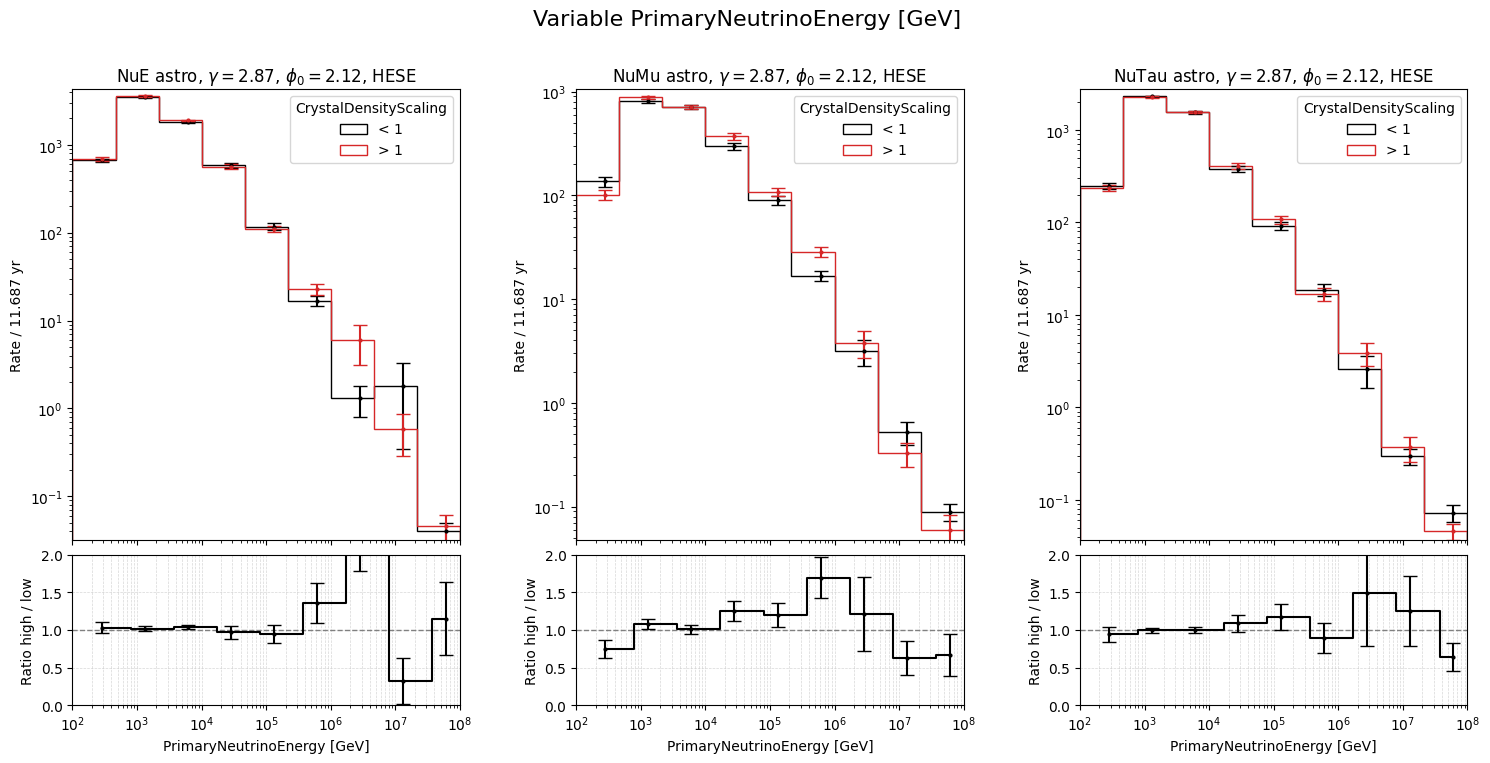

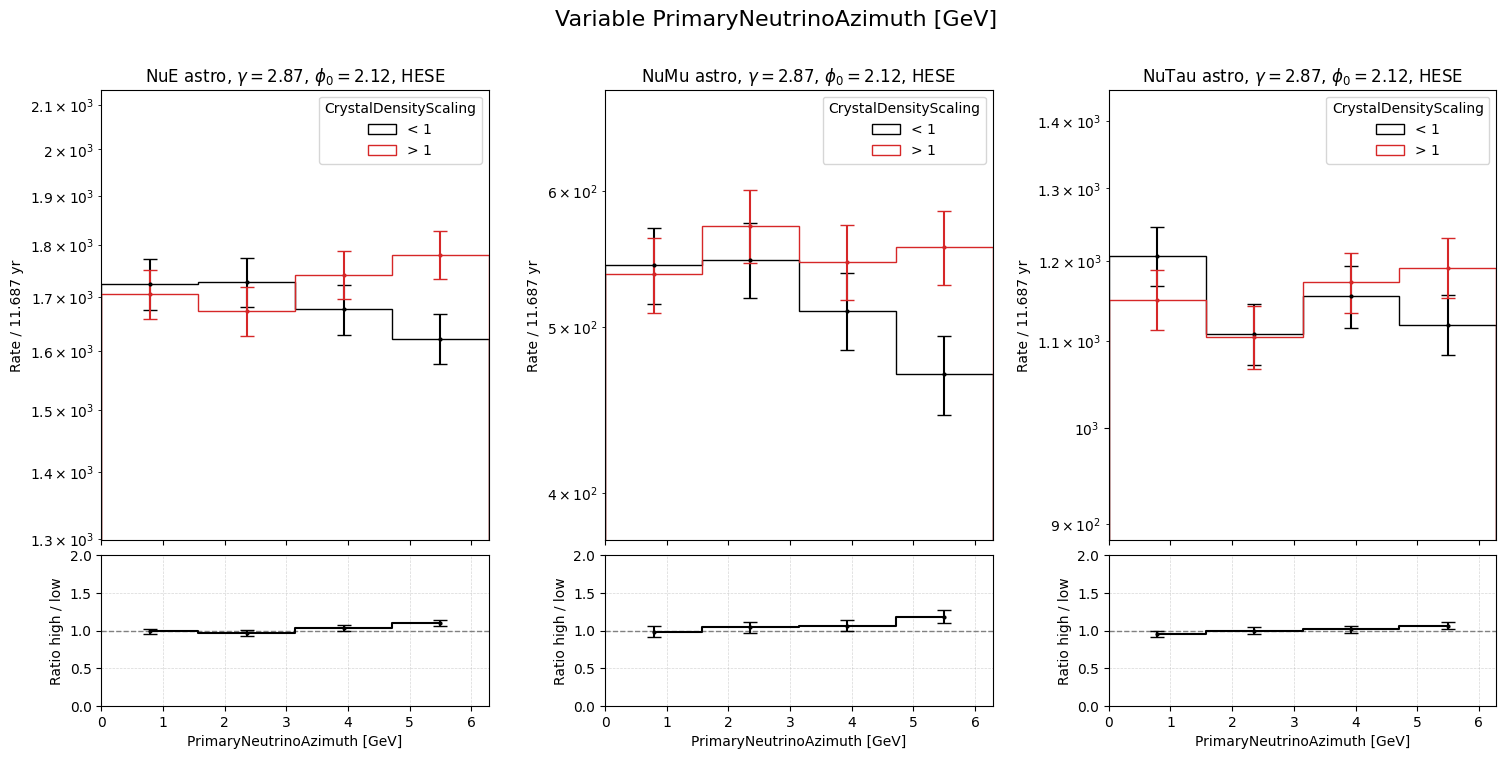

In [57]:
compare_dataset_flavor( base_key = "snowstorm_iceprod_benchmark_level3casc", base_var_key1 = "I3MCWeightDict", base_var_key2 = "PrimaryNeutrinoEnergy",
                        variable_name = "PrimaryNeutrinoEnergy [GeV]", bins = np.geomspace(1e2, 1e8, 10), xscale = "log", yscale = "log" )


compare_dataset_flavor( base_key = "snowstorm_iceprod_benchmark_level3casc", base_var_key1 = "I3MCWeightDict", base_var_key2 = "PrimaryNeutrinoAzimuth",
                        variable_name = "PrimaryNeutrinoAzimuth [GeV]", bins = np.linspace(0, 2*np.pi, 5), xscale = "linear", yscale = "log" )


Now for l2
- CascadeLlhVertexFit_L2
- LineFit
- MPEFit
- SPEFit2

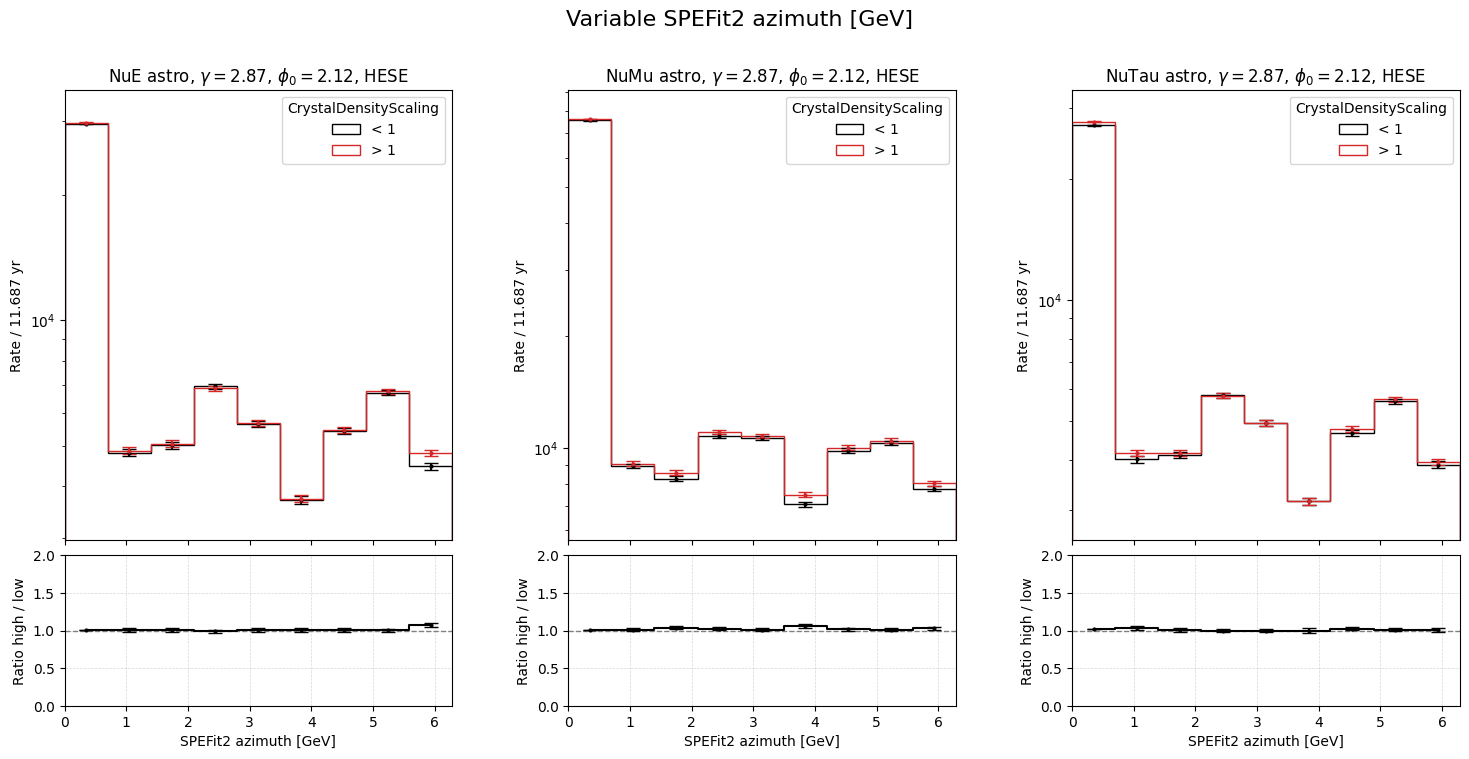

In [71]:
# compare_dataset_flavor( base_key = "snowstorm_iceprod_benchmark_level2", base_var_key1 = "SPEFit2", base_var_key2 = "azimuth",
#                         variable_name = "SPEFit2 azimuth [GeV]", bins = np.linspace(0, 2*np.pi, 10), xscale = "linear", yscale = "log" )

compare_dataset_flavor( base_key = "snowstorm_iceprod_benchmark_level2", base_var_key1 = "LineFit", base_var_key2 = "azimuth",
                        variable_name = "SPEFit2 azimuth [GeV]", bins = np.linspace(0, 2*np.pi, 10), xscale = "linear", yscale = "log" )



Lets do some reco variables for l3
- CscdL3_CascadeLlhVertexFit
- CscdL3_SPEFit16
- L3_MonopodFit4_AmptFit
- MPEFit
- SPEFit2

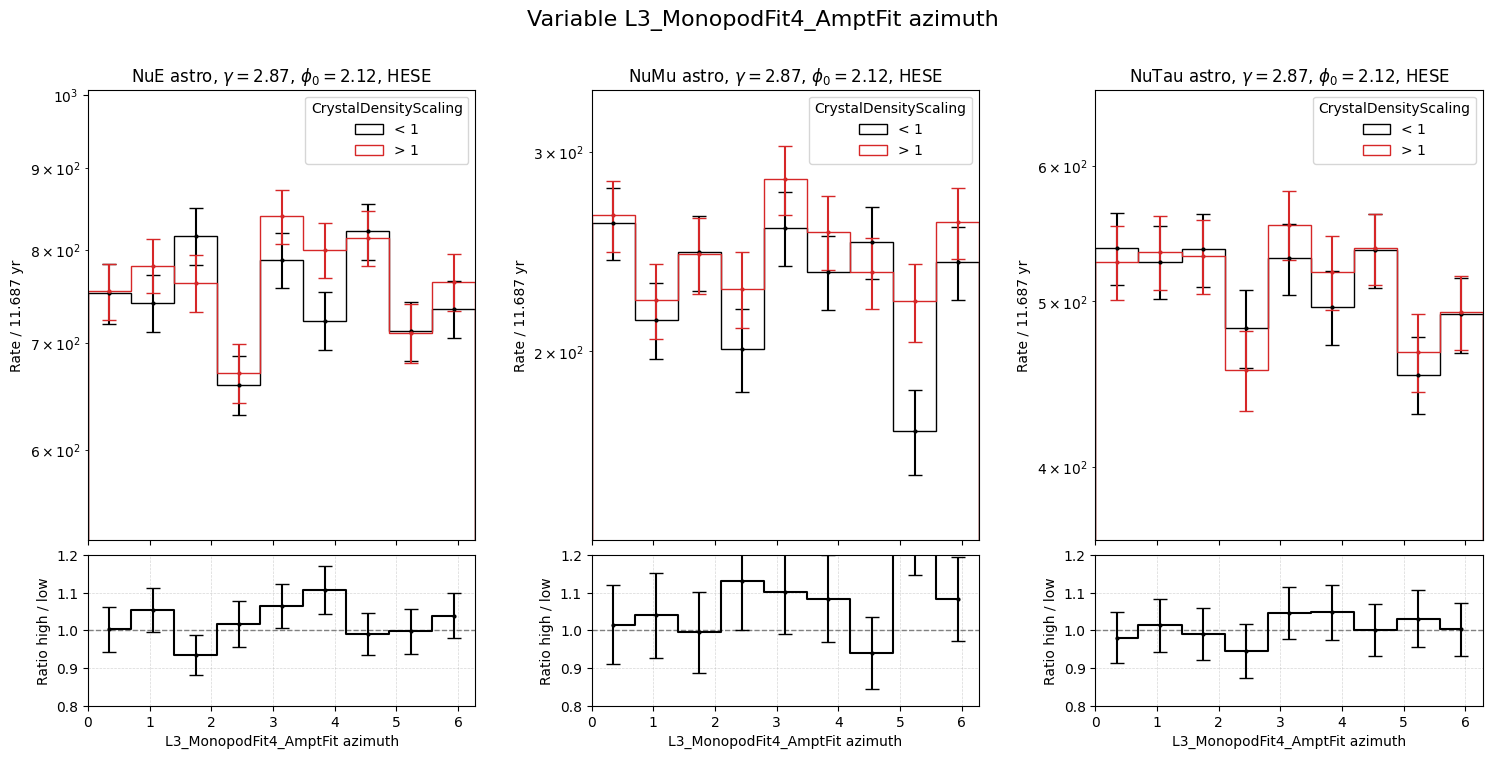

In [75]:
compare_dataset_flavor( base_key = "snowstorm_iceprod_benchmark_level3casc", base_var_key1 = "L3_MonopodFit4_AmptFit", base_var_key2 = "azimuth",
                        variable_name = "L3_MonopodFit4_AmptFit azimuth", bins = np.linspace(0, 2*np.pi, 10), xscale = "linear", yscale = "log" )
